# Import libraries

In [48]:
from typing import Sequence
from PIL import Image
import torch
import numpy as np
import colormaps
from torchvision import transforms
import math
import matplotlib.pyplot as plt
import itertools
from functools import partial
import sys
sys.path.append("/workspace/my_proposal/scripts")
from decode_heads import *
from detectron2.data.detection_utils import read_image
# from scripts.decode_heads import *
# Use timm's names
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)


# Functions

In [32]:
class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output
    
class MaybeToTensor(transforms.ToTensor):
    """
    Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor, or keep as is if already a tensor.
    """

    def __call__(self, pic):
        """
        Args:
            pic (PIL Image, numpy.ndarray or torch.tensor): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        if isinstance(pic, torch.Tensor):
            return pic
        return super().__call__(pic)

def make_normalize_transform(
    mean: Sequence[float] = IMAGENET_DEFAULT_MEAN,
    std: Sequence[float] = IMAGENET_DEFAULT_STD,
) -> transforms.Normalize:
    return transforms.Normalize(mean=mean, std=std)


def make_classification_eval_transform(
    *,
    resize_size: int = 256,
    interpolation=transforms.InterpolationMode.BICUBIC,
    crop_size: int = 224,
    mean: Sequence[float] = IMAGENET_DEFAULT_MEAN,
    std: Sequence[float] = IMAGENET_DEFAULT_STD,
) -> transforms.Compose:
    transforms_list = [
        transforms.Resize(resize_size, interpolation=interpolation),
        transforms.CenterCrop(crop_size),
        MaybeToTensor(),
        make_normalize_transform(mean=mean, std=std),
    ]
    return transforms.Compose(transforms_list)

# Backbone

In [42]:
BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

dinov2_vits14_reg = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
dinov2_vits14_reg.eval()


dinov2_vits14_reg.eval()
dinov2_vits14_reg.forward = partial(
    dinov2_vits14_reg.get_intermediate_layers,
    n=[8,9,10,11],
    reshape=True
)
if hasattr(dinov2_vits14_reg, "patch_size"):
    dinov2_vits14_reg.register_forward_pre_hook(lambda _, x: CenterPadding(dinov2_vits14_reg.patch_size)(x[0]))
dinov2_vits14_reg.init_weights()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:06<00:00, 13.9MB/s]


# Head

In [3]:
checkpoint = torch.load("/workspace/models/dinov2_vits14_voc2012_ms_head.pth",map_location="cpu")
state_dict = checkpoint['state_dict']

#Rename state_dict
from collections import OrderedDict
state_dict_rename = OrderedDict()
for key,val in state_dict.items():
    state_dict_rename[key.replace("decode_head.","")] = val

In [2]:
params = {
    "in_channels":[384, 384, 384, 384],
    "in_index":[0,1,2,3],
    "input_transform":"resize_concat",
    "channels":1536,
    "dropout_ratio":0,
    "num_classes":21,
    "norm_cfg":dict(type='SyncBN', requires_grad=True),
    "align_corners":False,
    "loss_decode":dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)

}
head = BNHead(
    resize_factors=None,
    **params
)

In [55]:
head.load_state_dict(state_dict_rename)
head.eval()

BNHead(
  input_transform=resize_concat, ignore_index=255, align_corners=False
  (conv_seg): Conv2d(1536, 21, kernel_size=(1, 1), stride=(1, 1))
  (bn): SyncBatchNorm(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# Load Image

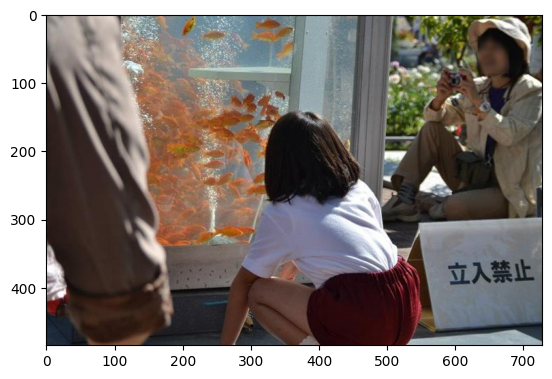

In [50]:
img = read_image("/workspace/data/ADE20K_2021_17_01/images/ADE/training/cultural/aquarium/ADE_frame_00000007.JPG")
plt.imshow(img)
plt.show()

In [53]:


DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}



def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)

transform = make_classification_eval_transform()
tensor = transform(Image.fromarray(img)).unsqueeze(0)
print(tensor.size())


torch.Size([1, 3, 224, 224])


# Inference

In [57]:
with torch.no_grad():
    features = dinov2_vits14_reg(tensor)
    seg_logits = head(features)
    print(seg_logits.size())

torch.Size([1, 21, 16, 16])


In [65]:
seg_label = F.sigmoid(seg_logits)
print(seg_label)

tensor([[[[9.9877e-01, 9.9878e-01, 9.9909e-01,  ..., 9.9866e-01,
           9.9687e-01, 9.9729e-01],
          [9.9694e-01, 9.9858e-01, 9.9786e-01,  ..., 9.9836e-01,
           9.9929e-01, 9.9737e-01],
          [9.9905e-01, 9.9591e-01, 9.9718e-01,  ..., 9.9957e-01,
           9.9917e-01, 9.9911e-01],
          ...,
          [9.9867e-01, 9.9725e-01, 9.9900e-01,  ..., 9.9853e-01,
           9.9939e-01, 9.9866e-01],
          [9.9789e-01, 9.9688e-01, 9.9906e-01,  ..., 9.9846e-01,
           9.9911e-01, 9.9834e-01],
          [9.9882e-01, 9.9185e-01, 9.9850e-01,  ..., 9.9844e-01,
           9.9737e-01, 9.9705e-01]],

         [[1.9823e-01, 4.2239e-01, 2.0749e-01,  ..., 7.6481e-02,
           7.6392e-01, 3.8240e-01],
          [2.4975e-01, 2.1540e-01, 1.8511e-01,  ..., 4.6775e-01,
           5.8736e-01, 7.5365e-01],
          [7.2562e-01, 5.6101e-01, 5.9079e-02,  ..., 8.5050e-01,
           3.4939e-01, 4.0283e-01],
          ...,
          [6.1140e-01, 1.5563e-01, 2.0655e-01,  ..., 7.4320

In [66]:
HEAD_DATASET = "voc2012"
segmented_image = render_segmentation(seg_label, HEAD_DATASET)
display(segmented_image)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [1]:
from mmseg.apis import init_model, inference_model
import mmcv
from mmengine.config import Config
import urllib
import sys
sys.path.append("/workspace/dinov2-main/")
import dinov2.eval.segmentation.models
from mmengine.runner import load_checkpoint

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_model, inference_model



class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_model(cfg,device="cpu")
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

In [3]:
BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/workspace/dinov2-main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/workspace/dinov2-main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/workspace/dinov2-main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [4]:
import urllib

def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_SCALE_COUNT = 3 # more scales: slower but better results, in (1,2,3,4,5)
HEAD_DATASET = "voc2012" # in ("ade20k", "voc2012")
HEAD_TYPE = "ms" # in ("ms, "linear")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = Config.fromfile("/workspace/my_proposal/config.py")
if HEAD_TYPE == "ms":
    cfg.data.test.pipeline[1]["img_ratios"] = cfg.data.test.pipeline[1]["img_ratios"][:HEAD_SCALE_COUNT]
    print("scales:", cfg.data.test.pipeline[1]["img_ratios"])

model = create_segmenter(cfg, backbone_model=backbone_model)
load_checkpoint(model, head_checkpoint_url, map_location="cpu")

model.eval()

scales: [1.0, 1.32, 1.73]
12/04 15:35:17 - mmengine - INFO - 
decode_head.conv_seg.weight - torch.Size([21, 1536, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
12/04 15:35:17 - mmengine - INFO - 
decode_head.conv_seg.bias - torch.Size([21]): 
NormalInit: mean=0, std=0.01, bias=0 
 
12/04 15:35:17 - mmengine - INFO - 
decode_head.bn.weight - torch.Size([1536]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 
12/04 15:35:17 - mmengine - INFO - 
decode_head.bn.bias - torch.Size([1536]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 
Loads checkpoint by http backend from path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_voc2012_ms_head.pth


/usr/local/lib/python3.9/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/usr/local/lib/python3.9/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


EncoderDecoder(
  (data_preprocessor): BaseDataPreprocessor()
  (backbone): DinoVisionTransformer()
  (decode_head): BNHead(
    input_transform=resize_concat, ignore_index=255, align_corners=False
    (loss_decode): CrossEntropyLoss(avg_non_ignore=False)
    (conv_seg): Conv2d(1536, 21, kernel_size=(1, 1), stride=(1, 1))
    (bn): SyncBatchNorm(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  init_cfg={'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
)

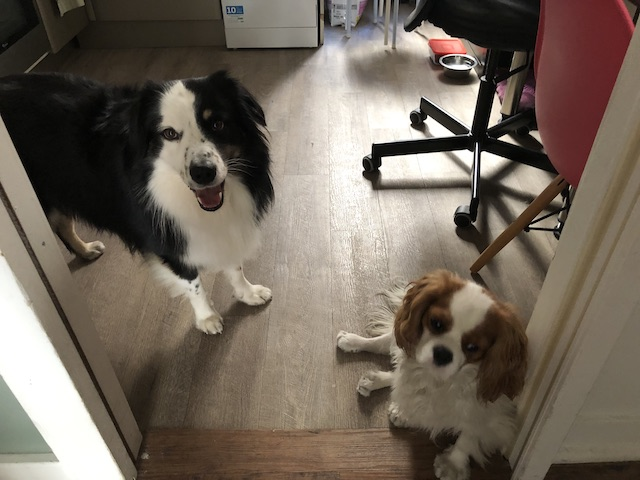

In [5]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"


image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(image)

In [7]:
import numpy as np

import dinov2.eval.segmentation.utils.colormaps as colormaps


DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}


def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)


array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_model(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, HEAD_DATASET)
display(segmented_image)

KeyError: 'inputs'